In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/bsds_challenge')

In [4]:
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

# Data Exploration

In [5]:
train.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1479051004,11/13/2016 12:00:00 AM,05:30:04,1.19,44,30.44,55,171.19,4.50,06:30:00,17:44:00
1,1478606702,11/8/2016 12:00:00 AM,02:05:02,1.21,45,30.41,40,109.97,4.50,06:27:00,17:45:00
2,1482031817,12/17/2016 12:00:00 AM,17:30:17,3.22,51,30.26,92,113.37,3.37,06:51:00,17:47:00
3,1482747940,12/26/2016 12:00:00 AM,00:25:40,1.21,44,30.45,102,76.27,4.50,06:55:00,17:51:00
4,1476884417,10/19/2016 12:00:00 AM,03:40:17,1.22,48,30.42,69,167.43,9.00,06:19:00,17:56:00


In [6]:
train.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.105100e+04,31051.000000,31051.000000,31051.000000,31051.000000,31051.000000,31051.000000
mean,1.478044e+09,207.032862,51.106631,30.422832,75.021545,143.428964,6.244306
std,3.005559e+06,315.904121,6.194944,0.054617,25.992570,83.150255,3.496223
min,1.472724e+09,1.130000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475541e+09,1.230000,46.000000,30.400000,56.000000,82.170000,3.370000
50%,1.478015e+09,2.660000,50.000000,30.430000,85.000000,147.660000,5.620000
75%,1.480480e+09,353.745000,55.000000,30.460000,97.000000,179.280000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


In [7]:
(train.isnull().sum()).sum()

0

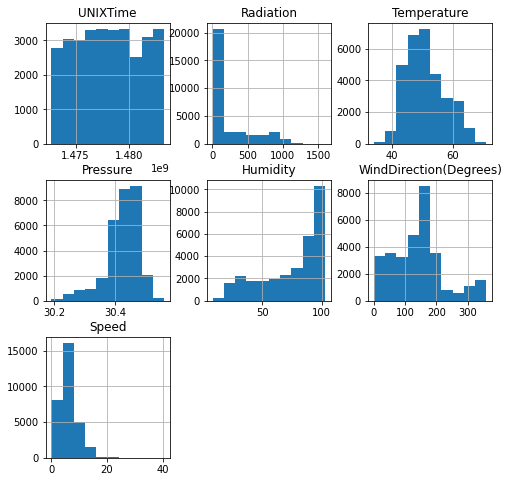

In [8]:
train.hist(figsize=[8,8])
plt.show()

In [9]:
train.corr()["Radiation"].sort_values(ascending = False)

Radiation                 1.000000
Temperature               0.735168
Pressure                  0.118075
Speed                     0.074403
UNIXTime                 -0.082560
Humidity                 -0.225064
WindDirection(Degrees)   -0.232061
Name: Radiation, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(1.13, 1602.0)

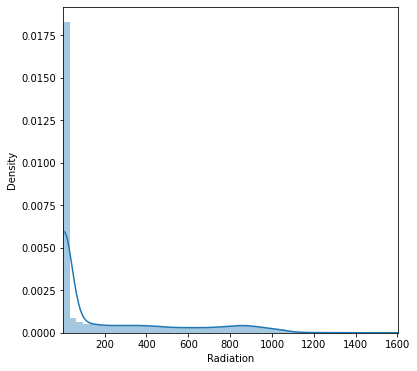

In [10]:
f, ax = plt.subplots(figsize=(6,6))
sns.distplot(train['Radiation'])
plt.xlim([1.13,1602])

We realized that all the measurement of time were taken in a timezone 10 hours ahead of the utc time, which corresponds to the Hawaiian time. 

In [11]:
def get_date(s):
    l = s.split()
    return l[0]

In [12]:
datetime_local = (train['Data'].apply(get_date) + ' ' + train['Time']).apply(pd.Timestamp)

In [13]:
datetime_utc = train['UNIXTime'].apply(datetime.datetime.utcfromtimestamp)

In [14]:
(datetime_utc - datetime_local).value_counts()

0 days 10:00:00    31051
dtype: int64

# Feature Engineering

We noticed that time was represented with several columns in the dataset. In order to be able to use the Time measurement, the TimeSunRise and TimeSunSet, we converted all those time columns to the seconds elapsed from the midnight of the current day.
We kept UNIXTime as an absolute representation and we extracted a relative representation, with respect to sunrise and sunset. Hence, we created a new column called TimeFromSunRise. The data of this column represents the spread in seconds between the data collection and the sunrise, a negative value represents an event before sunrise and a positive value represents an event happened after it. We did the same with TimeFromSunSet. We then dropped the original columns, because all the relevant information is contained in the two newly created columns.

In [15]:
def time_to_seconds(s):
    dt = datetime.datetime.strptime(s, "%H:%M:%S") - datetime.datetime(1900,1,1)
    return dt.total_seconds()

In [16]:
train["Time"] = train["Time"].apply(time_to_seconds)
train["TimeSunRise"] = train["TimeSunRise"].apply(time_to_seconds)
train["TimeSunSet"] = train["TimeSunSet"].apply(time_to_seconds)
train['TimeFromSunRise'] = train['Time'] - train['TimeSunRise']
train['TimeFromSunSet'] = train['Time'] - train['TimeSunSet']
train.drop(columns=['Time', 'TimeSunRise', 'TimeSunSet', 'Data'], inplace=True)

# Model Selection and Tuning

We performed a preliminary evaluation of some of the possible models to get a benchmark and tree-based models seemed a suitable choice for the problem.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns='Radiation'), train['Radiation'], test_size = 0.2, random_state = 42)
regressors = [LinearRegression(),
              XGBRegressor(),
              RandomForestRegressor()]

for model in regressors:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = mean_squared_error(y_test, predictions)
    print(f'MSE {type(model).__name__}: {error}')

MSE LinearRegression: 37329.80942877854
[21:08:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE XGBRegressor: 10947.560779448626
MSE RandomForestRegressor: 6337.97540160891


Given the smaller MSE we got with XGBoost and Random Forest, we proceeded with the tuning of these two models. However, from the output below, we realised that the fifth and sixth features corresponding to WindDirection(Degrees) and Speed have significantly lower impact on the result compared to the other features. We inferred that wind data may not be that relevant in estimating solar radiation, hence we dropped those columns.

In [18]:
random_forest.feature_importances_ 

array([0.04429757, 0.52666752, 0.01435791, 0.04360323, 0.04134855,
       0.00654623, 0.20099099, 0.12218801])

In [19]:
xgb.feature_importances_

array([0.0120017 , 0.7728354 , 0.01003255, 0.02065095, 0.00603164,
       0.00464296, 0.1046446 , 0.06916027], dtype=float32)

In [20]:
features = train.drop(columns=['Radiation', 'WindDirection(Degrees)', 'Speed'])
target = train['Radiation']

The models will be trained on this dataset:

In [21]:
features.head()

,UNIXTime,Temperature,Pressure,Humidity,TimeFromSunRise,TimeFromSunSet
0,1479051004,44,30.44,55,-3596.0,-44036.0
1,1478606702,45,30.41,40,-15718.0,-56398.0
2,1482031817,51,30.26,92,38357.0,-1003.0
3,1482747940,44,30.45,102,-23360.0,-62720.0
4,1476884417,48,30.42,69,-9523.0,-51343.0


In [22]:
#RANDOM FOREST TUNING:
param_grid = {'n_estimators': np.arange(500, 700, 10),
              'max_depth': np.arange(4, 21),
              'min_samples_split': [0.001, 0.01, 0.1, 2],
              'min_samples_leaf': [0.001, 0.01, 0.1, 1],
              'max_features': np.arange(3, 7), 
              'n_jobs': [-1]
              }

rf = RandomForestRegressor()
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=25, scoring='neg_mean_squared_error', n_jobs=-1, refit=False)
random_search.fit(features, target)

In [23]:
# XGB TUNING:
param_grid = {'learning_rate': np.arange(0.01, 0.1, 0.01),
              'n_estimators': np.arange(2, 500, 10), 
              'subsample': [0.7, 0.8, 0.9, 1.0],
              'max_depth': np.arange(4,21), 
              'min_samples_split': [0.001, 0.01, 0.1, 2],
              'min_samples_leaf': [0.001, 0.01, 0.1, 1],
              'n_jobs': [-1]
              }

xgb = XGBRegressor()
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=30, scoring='neg_mean_squared_error', n_jobs=-1, refit=False)
random_search.fit(features, target)

In [24]:
# Tuned Models:
rf = RandomForestRegressor(n_estimators = 550,
                           max_depth = 19,
                           max_features = 3,
                           random_state = 42,
                           n_jobs = -1)

xgb = XGBRegressor(learning_rate = 0.06, 
                   estimators = 2, 
                   max_depth = 11, 
                   min_samples_leaf = 1, 
                   min_samples_split = 0.001, 
                   subsample = 0.7)

# Performance Evaluation

The evaluation of the performance was carried out through 5-fold cross-validation. The tuned models performed similarly on average, but slightly differently on individual folds. We resorted to ensemble models to reduce such variance. 

In [25]:
estimators = [('rf', rf), ('xgb', xgb)]
kf = KFold(shuffle=True, random_state=42)

In [26]:
for _, estimator in estimators:
    scores = cross_val_score(estimator, features, target, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    print(f'{type(estimator).__name__}: scores: {scores}, avg: {np.mean(scores)}')

RandomForestRegressor: scores: [-5805.08689299 -5678.18160476 -5457.42742249 -5785.62709706
 -6150.77549273], avg: -5775.419702004989
XGBRegressor: scores: [-5922.18257052 -5581.86767986 -5461.14508537 -5803.76775836
 -6066.7315909 ], avg: -5767.138936998545


# Final Model

We evaluated three ensemble estimators: 

*   Voting Regressor, averaging the predictions of base estimators
*   Stacking Regressor, with Ridge Regression as final estimator
*   Stacking Regressor, with Elastic Net Regression as final estimator
 
Final results were satisfactory: this additional layer of ensemble led to a significant improvement with respect to individual models. The difference among the three was minimal and we chose Voting Regressor for our final submission. 

In [27]:
elastic_net = ElasticNetCV()
ensemble_models = [VotingRegressor(estimators, n_jobs=-1),
                   StackingRegressor(estimators, cv=kf, n_jobs=-1),
                   StackingRegressor(estimators, elastic_net, cv=kf, n_jobs=-1)]

for model in ensemble_models:
    scores = cross_val_score(model, features, target, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
    print(f'{type(model).__name__}: scores: {scores}, avg: {np.mean(scores)}')

VotingRegressor: scores: [-5757.47973803 -5533.29428142 -5366.29675692 -5700.56061714
 -6001.25745418], avg: -5671.777769537201


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


StackingRegressor: scores: [-5797.98007144 -5524.04732098 -5373.9898584  -5705.0775772
 -5994.46318441], avg: -5679.111602486854
StackingRegressor: scores: [-5781.44661537 -5526.47645416 -5368.24551806 -5701.17609721
 -5995.92586299], avg: -5674.65410955815


In [28]:
voting = VotingRegressor(estimators, n_jobs=-1)
voting.fit(features, target)

In [29]:
test["Time"] = test["Time"].apply(time_to_seconds)
test["TimeSunRise"] = test["TimeSunRise"].apply(time_to_seconds)
test["TimeSunSet"] = test["TimeSunSet"].apply(time_to_seconds)
test['TimeFromSunRise'] = test['Time'] - test['TimeSunRise']
test['TimeFromSunSet'] = test['Time'] - test['TimeSunSet']
test.drop(columns = ['Time', 'TimeSunRise', 'TimeSunSet', 'Data', 'WindDirection(Degrees)', 'Speed'], inplace=True)

In [30]:
prediction = voting.predict(test)
np.savetxt('BSDS_May_Profito_predictions.txt', prediction)